<a href="https://colab.research.google.com/github/jacquelinedoan/pricing_causal/blob/main/pricing_causal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Heckman Correction, Instrumental Variable, and DoubleML for Demand Modelling with Censored Purchase Data**

For a given customer $i$ and product $j$ (and context $x$), we want price $p^*$ such that
$$p^* = \text{argmax}_p \text{ profit} (p|x) = (p-c)\times E(D(p|x))$$

where
*   $c$: unit cost
*   $D(p|x)$: expected demand at price $p$ given context $x$

Expected demand is defined as the quantity sold, which is a product-level concept. Thus the master table will be snapshots of product at a certain price, with the quantity sold.

In [2]:
!pip install doubleml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.8/471.8 kB 14.1 MB/s eta 0:00:00


## Data Preparation

In [47]:
import os
import numpy as np
import pandas as pd
import kagglehub

pd.set_option('display.max_columns', None)

# Kaggle Data
path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")

In this use case, I use a public dataset sourced from Kaggle. Our data contains only purchase records, thus we have no records about prices when there are no sales. We will need to aggregate the table so that we have a column for "quantity" on the customer and product level. We will also have to define aggregation schemes for the rest of the columns.

In [62]:
cust, sell, rev, item, prod, geo, cat, orders, pay = [pd.read_csv(f"{path}/{file}") for file in os.listdir(path)]
master = orders.merge(cust, on="customer_id", how='left')\
               .merge(item, on="order_id", how='left')\
               .merge(prod, on="product_id", how='left')\
               .merge(cat, on="product_category_name", how='left')\
               .merge(sell, on="seller_id", how='left')

#  .merge(rev, on="order_id", how='left')
#  .merge(pay, on="order_id", how='left')\

# Drop entries where price is null
master.dropna(subset=['price'], inplace=True)
master.reset_index(drop=True, inplace=True)

# Handle Datetime data
master['order_purchase_timestamp'] = pd.to_datetime(master.order_purchase_timestamp,
                                             format='%Y-%m-%d %H:%M:%S')
master['order_estimated_delivery_date'] = pd.to_datetime(master.order_estimated_delivery_date,
                                              format='%Y-%m-%d %H:%M:%S')
master['days_to_delivery'] = (master.order_estimated_delivery_date - master.order_purchase_timestamp).dt.days

master['order_purchase_weekday'] = master['order_purchase_timestamp'].dt.day_name()

# Purchase Indicator
master['Purchased'] = (master['order_status'] != 'canceled').astype(int)

In [63]:
master.select_dtypes(include=['object']).columns

Index(['order_id', 'customer_id', 'order_status', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'customer_unique_id', 'customer_city', 'customer_state', 'product_id',
       'seller_id', 'shipping_limit_date', 'product_category_name',
       'product_category_name_english', 'seller_city', 'seller_state',
       'order_purchase_weekday'],
      dtype='object')

In [66]:
drop_cols = [
            'order_approved_at',
            'order_delivered_carrier_date',
            'order_delivered_customer_date',
            'order_estimated_delivery_date',
            'order_purchase_timestamp',
            'seller_id',
            'shipping_limit_date',
            'seller_city',
            'seller_state',
            'product_name_lenght',
            'product_description_lenght',
            'product_photos_qty',
            'product_category_name'
             ]

In [67]:
data = master.drop(columns=drop_cols).drop_duplicates()
data.select_dtypes(include=['object']).columns

Index(['order_id', 'customer_id', 'order_status', 'customer_unique_id',
       'customer_city', 'customer_state', 'product_id',
       'product_category_name_english', 'order_purchase_weekday'],
      dtype='object')

In [96]:
data.dtypes

,0
order_id,object
customer_id,object
order_status,object
customer_unique_id,object
customer_zip_code_prefix,int64
customer_city,object
customer_state,object
order_item_id,float64
product_id,object
price,float64


In [98]:
data.groupby(by=['customer_id', 'product_id', 'price']).agg(
    {
        # Count quantity ordered
        'order_id': 'count',
        # Numerical
        'freight_value': 'max',
        'product_weight_g': 'max',
        'product_length_cm': 'max',
        'product_height_cm': 'max',
        'product_width_cm': 'max',
        'days_to_delivery': 'max',
        # Categorical
        'customer_city': 'first',
        'customer_state': 'first',
        'customer_zip_code_prefix': 'first',
        'product_name_lenght': 'first',
        'product_description_lenght': 'first',
        'product_photos_qty': 'first',
        'product_category_name': 'first',

    }
).reset_index().sort_values(by='price',ascending=False).rename(columns={'order_id': 'quantity'})

,customer_id,product_id,price,quantity,freight_value
79856,c6e2731c5b391845f6800c97401a43a9,489ae2aa008f021502940f251d4cce7f,6735.00,1,194.31
97997,f48d464a0baaea338cb25f816991ab1f,69c590f7ffc7bf8db97190b6cb6ed62e,6729.00,1,193.21
25522,3fd6777bbce08a352fddd04e4a7cc8f6,1bdf5e6731585cf01aa8169c7028d6ad,6499.00,1,227.66
89543,df55c14d1476a9a3467f131269c2477f,a6492cc69376c469ab6f61d8f44de961,4799.00,1,151.34
14730,24bbf5fd2f2e1b359ee7de94defc4a15,c3ed642d592594bb648ff4a04cee2747,4690.00,1,74.34
...,...,...,...,...,...
100927,fc3d1daec319d62d49bfb5e1f83123e9,05b515fdc76e888aada3c6d66c201dff,1.20,10,7.89
100928,fc3d1daec319d62d49bfb5e1f83123e9,270516a3f41dc035aa87d220228f844c,1.20,10,7.89
8816,161b6d415e8b3413c6609c70cf405b5a,8a3254bee785a526d548a81a9bc3c9be,0.85,1,18.23
63897,9f9d249355f63c5c1216a82b802452c1,8a3254bee785a526d548a81a9bc3c9be,0.85,1,18.23


<Axes: xlabel='price'>

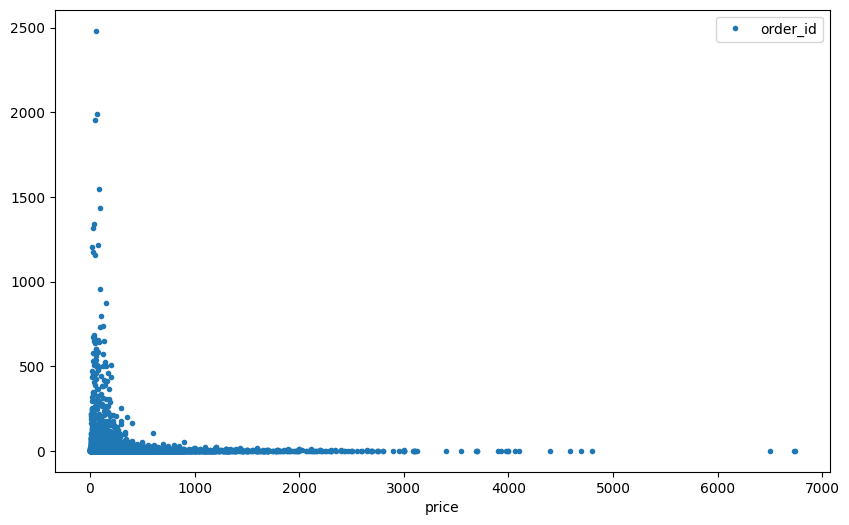

In [91]:
data.groupby(by=['price']).order_id.count().reset_index().sort_values(by='price').plot(x='price', y='order_id', marker='.', linestyle=' ', figsize=(10, 6))

In [ ]:
# Null Treatment
# Categorical
master.select_dtypes(include=['object']).fillna('Unknown', inplace=True)
# Numerical
master.fillna(0, inplace=True)

**Problem Set-Up**:


1.   Endogenous Variable: price is partially determined by demand. **Need Instrumental Variable.**

2.   Censored Data: decision to not purchase is not observable. **Need Selection Correction.**

Dynamic pricing requires a demand model/ demand curve. A demand curve is the relationship between the quantity demanded (or propensity to purchase) and the price among other features.


## Instrumental Variable
We want to estimate the response of market demand to exogenous changes in market prices. Quantity demanded depends on prices, but prices are not exogenously given since they are determined in part by market demand. The instrument for price is a variable that is correlated with price but does not directly effect quantity demanded, ideally a supply-inducing variable.

**IV ($Z$) Requirements**
1.   **Relevance**: $\text{Cov}(Z,\text{price}) \neq 0$
2.   **Exclusion/ Validity**: $Z \perp ϵ$ where $ϵ$ unobserved demand shock.

Some candidates:


*   Supply-side shock: supplier cost change, wholesale price, shipping cost (shift retail price but doesn't directly affect demand)
*   Day-of-week, temporary promotions (only if random scheduling)
* Regional difference: warehouse stock levels, local supply constraints (only if no difference in preference across regions)







In [ ]:
# Possible Instrumental Variables
iv = [
    'order_purchase_weekday', # day of the week
    'freight_value', # shipping cost
    'seller_state', # proxy for regional supply shock
     ]

In [ ]:
price = ['price']

covariates = [
       'days_to_delivery',
       'customer_zip_code_prefix',
      #  'customer_city',
       'customer_state',
       'product_category_name',
       'product_name_lenght',
       'product_description_lenght',
       'product_photos_qty',
       'product_weight_g',
       'product_length_cm',
       'product_height_cm',
       'product_width_cm',
       'seller_zip_code_prefix',
      #  'seller_city',
       'seller_state',
       'payment_sequential',
       'payment_type',
       'payment_installments',
       'payment_value',
       'review_score',
       ]

In [ ]:
# Empirical Check for Relevance
X = master[covariates]
Z = master[iv]
y = master[price]

In [ ]:
XZ = sm.add_constant(pd.concat([X, Z], axis=1))

In [ ]:
# Empirical Check for Relevance
import statsmodels.api as sm

XZ = sm.add_constant(pd.concat([X, Z], axis=1))

# One-hot encode categorical columns in XZ
XZ_encoded = pd.get_dummies(XZ, columns= XZ.select_dtypes(include=['object']).columns,
                            dummy_na=False)

In [ ]:
# An overview look of the IV. F Statistic is > 10, the instruments chosen are strong
relevance = sm.OLS(y, XZ_encoded.astype(float)).fit()
print(relevance.fvalue)

1372.4823046484248


In [ ]:
# # Conditional Regressions (Sanderson-Windmeijer, 2016)
# # We have strong instruments
# X = master[covariates]
# Z = master[iv]
# y = master[price]

# Z_encoded = pd.get_dummies(Z,
#                             columns=Z.select_dtypes(include=['object']).columns,
#                             dummy_na=False)
# X_encoded = pd.get_dummies(X,
#                             columns=X.select_dtypes(include=['object']).columns,
#                             dummy_na=False)

# for z in Z_encoded.columns:
#     print(f"Conditional Regression for {z}:")
#     other_Z = Z_encoded.drop(columns=[z])
#     XZ_other = sm.add_constant(pd.concat([X_encoded, other_Z], axis=1))
#     # y = master[price]
#     y=Z_encoded[z]
#     model = sm.OLS(y, XZ_other.astype(float)).fit()

#     f_stat = model.fvalue
#     p_val = model.f_pvalue

#     print(f"Conditional F-test for {z}: F={f_stat:.2f}, p={p_val:.4f}")

## Heckman Correction

*   **Definition** (Selection Equation): The individual sampling probability of each observation
*   **Definition** (Outcome Equation): The conditional expectation of the dependent variable

**Two Stages of Heckman Correction**
1.   Estimate the probability of purchase. Here, we will use XGBoost to estimate
$$\hat{p}_i = P(S_i =1|z_i)$$
where $S_i=1$ means the purchase is observed and $z_i$ are instruments/ exclusion variables, affecting selection, but not directly purchase outcome.
2.   Correct for self-selection by incorporating a transformation of these predicted individual probabilities as an explanatory variable. This is done by computing the **inverse Mills ratio** for each observation $i$
$$\lambda_i = \frac{\phi(\Phi^{-1}(\hat{p}_i))}{\hat{p}_i}$$
and use the ratio as a control in outcome regression.


In [ ]:
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import norm

In [ ]:
X = master[covariates]
Z = master[iv]
y = master[price].values

In [ ]:
# Selection Model
X_selection = master[covariates+iv]
y_selection = master['S']

# XGBoost classifier for selection
ml_selector = XGBClassifier(eval_metric='logloss',
                            )

# Perform one-hot encoding on X_selection
X_selection_encoded = pd.get_dummies(X_selection,
                                     columns=X_selection.select_dtypes(include='object').columns,
                                     dummy_na=False)

ml_selector.fit(np.array(X_selection_encoded), np.array(y_selection))
# Predict selection probability per observation
p_hat = ml_selector.predict_proba(np.array(X_selection_encoded))[:, 1]
# Compute IMR (inverse Mills ratio) for Heckman-style correction
imr = norm.pdf(norm.ppf(np.clip(p_hat, 1e-6, 1-1e-6))) / np.clip(p_hat, 1e-6, 1-1e-6)
master['imr'] = imr

In [ ]:
# Outcome model
from doubleml import DoubleMLData, DoubleMLPLR

X_outcome = master[covariates+['imr', 'S', 'price']]

# One-hot encode categorical columns in XZ
X_outcome_encoded = pd.get_dummies(
                          X_outcome,
                          columns=X_outcome.select_dtypes(include=['object']).columns,
                          dummy_na=False)

dml_data = DoubleMLData(data=X_outcome_encoded[X_outcome_encoded.S==1],
                        y_col='S', # outcome
                        d_cols='price', # treatment
                        x_cols= X_outcome_encoded.drop(columns=['S', 'price']).columns.tolist(), # covariates
                        )

# Double ML
ml_l = XGBRegressor(n_estimators=100, max_depth=3)
ml_m = XGBRegressor(n_estimators=100, max_depth=3)

dml_plr = DoubleMLPLR(dml_data, ml_l=ml_l, ml_m=ml_m)
dml_plr.fit()

# Treatment effect estimate
print("Theta_hat:", dml_plr.coef)
print("Std. Error:", dml_plr.se)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Theta_hat: [0.]
Std. Error: [0.]


/usr/local/lib/python3.12/dist-packages/doubleml/utils/_sensitivity.py:6: RuntimeWarning: invalid value encountered in divide
  psi_max_bias = np.divide(np.add(np.multiply(sigma2, psi_nu2), np.multiply(nu2, psi_sigma2)), np.multiply(2.0, max_bias))
